In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import List

In [42]:
x_values = np.linspace(-3, 3, 1000)
y_values = np.cos(4 * np.pi * x_values) - np.sin(np.pi * (x_values ** 2)) * np.cos(np.pi * (x_values ** 3))

In [43]:
x_MLP=x_values
y_MLP=y_values
x_RBF = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
y_RBF = torch.tensor(y_values, dtype=torch.float32).view(-1, 1)

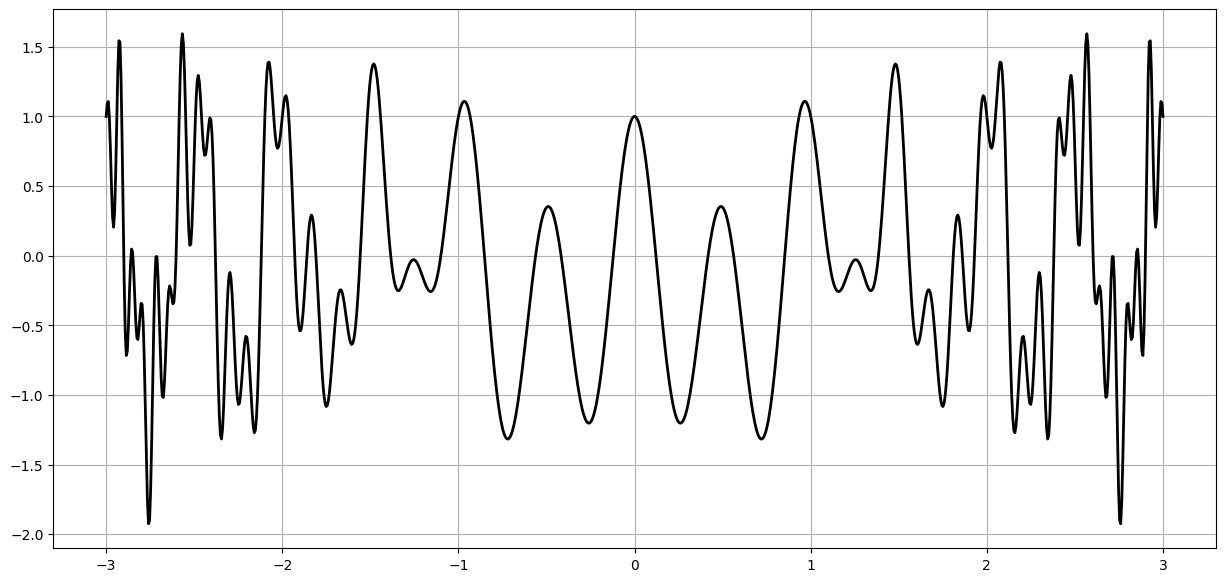

In [44]:
plt.figure(figsize=(15, 7))
plt.plot(x_values, y_values, color='black', linewidth=2, label="Actual graph")
plt.grid(True)

In [45]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(1, 24)
        self.activation1 = nn.Tanh()

        self.fc2=nn.Linear(24,24)
        self.activation2 =nn.Tanh()

        self.fc3 = nn.Linear(24, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        return x

In [46]:
def get_optimizer(optimizer_name, model,lr=0.0001):
  if optimizer_name == "ADAM":
      return optim.Adam(model.parameters(),lr=lr)
  elif optimizer_name == "LBFGS":
      return optim.LBFGS(model.parameters())
  raise ValueError('Chosen optimizer is unavailable.')


def train(model, optimizer, criterion, inputs, targets):
    def closure():
        optimizer.zero_grad()
        outputs = model(inputs)
        mse_loss = criterion(outputs, targets)  # element-wise squared error
        rmsd_loss = torch.sqrt(mse_loss.mean())  # take mean and sqrt
        rmsd_loss.backward()
        return rmsd_loss
    optimizer.step(closure)
    return closure().item()


def evaluate(model, x_test):
    model.eval()
    with torch.no_grad():
        y_pred_MLP = model(x_test.view(-1, 1)).numpy()
    return y_pred_MLP

In [47]:
model_MLP = MLP()
criterion_MLP = nn.MSELoss(reduction='none')
optimizer_MLP = get_optimizer('ADAM', model_MLP,lr=0.0001)


In [48]:
loss_history_MLP=[]
num_epochs = 20000
for epoch in range(num_epochs):
    # Convert data to PyTorch tensors
    inputs = torch.tensor(x_MLP, dtype=torch.float32, requires_grad=True).view(-1, 1)
    targets = torch.tensor(y_MLP, dtype=torch.float32).view(-1, 1)

    # Training
    loss = train(model_MLP, optimizer_MLP, criterion_MLP, inputs, targets)
    loss_history_MLP.append(loss)
    if (epoch+1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

Epoch [1000/20000], Loss: 0.7576
Epoch [2000/20000], Loss: 0.7556
Epoch [3000/20000], Loss: 0.7537
Epoch [4000/20000], Loss: 0.7528
Epoch [5000/20000], Loss: 0.7520
Epoch [6000/20000], Loss: 0.7481
Epoch [7000/20000], Loss: 0.7358
Epoch [8000/20000], Loss: 0.7228
Epoch [9000/20000], Loss: 0.7060
Epoch [10000/20000], Loss: 0.6699
Epoch [11000/20000], Loss: 0.6331
Epoch [12000/20000], Loss: 0.6135
Epoch [13000/20000], Loss: 0.6061
Epoch [14000/20000], Loss: 0.6029
Epoch [15000/20000], Loss: 0.5982
Epoch [16000/20000], Loss: 0.5902
Epoch [17000/20000], Loss: 0.5823
Epoch [18000/20000], Loss: 0.5735
Epoch [19000/20000], Loss: 0.5653
Epoch [20000/20000], Loss: 0.5558


In [49]:
x_tensor_MLP = torch.tensor(x_MLP, dtype=torch.float32)
y_pred_MLP = evaluate(model_MLP, x_tensor_MLP)

In [50]:
class RadialBasisFunctionNetwork(nn.Module):
    def __init__(self, hidden_layers: List[int], min_grid: float = -1., max_grid: float = 1., grid_count: int = 5, apply_base_update: bool = False, activation: nn.Module = nn.SiLU(), grid_opt: bool = False, dtype: torch.dtype = torch.float32, noise_scale: float = 0.1):
        super().__init__()
        self.layers = nn.ModuleList()
        # First layer with specified min_grid and max_grid
        self.layers.append(RadialBasisFunctionLayer(hidden_layers[0], hidden_layers[1], min_grid, max_grid, grid_count, apply_base_update, activation, grid_opt, dtype, noise_scale))
        # Subsequent layers with min_grid and max_grid set to -1 and 1
        for in_dim, out_dim in zip(hidden_layers[1:-1], hidden_layers[2:]):
            self.layers.append(RadialBasisFunctionLayer(in_dim, out_dim, -1., 1., grid_count, apply_base_update, activation, grid_opt, dtype, noise_scale))
        self.dtype = dtype

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(self.dtype)
        for layer in self.layers[:-1]:
            x = torch.tanh(layer(x))
        x = self.layers[-1](x)
        return x

class RadialBasisFunctionLayer(nn.Module):
    def __init__(self, in_features: int, out_features: int, min_grid: float = -1., max_grid: float = 1., grid_count: int = 5, apply_base_update: bool = False, activation: nn.Module = nn.SiLU(), grid_opt: bool = False, dtype: torch.dtype = torch.float32, noise_scale: float = 0.1):
        super().__init__()
        self.apply_base_update = apply_base_update
        self.activation = activation
        self.min_grid = min_grid
        self.max_grid = max_grid
        self.grid_count = grid_count
        self.grid = nn.Parameter(torch.linspace(min_grid, max_grid, grid_count, dtype=dtype), requires_grad=grid_opt)
        self.rbf_weight = nn.Parameter(torch.empty(in_features * grid_count, out_features, dtype=dtype))
        self.scale_base = nn.Parameter(torch.ones(out_features, dtype=dtype))
        self.scale_rbf = nn.Parameter(torch.ones(out_features, dtype=dtype))

        nn.init.xavier_normal_(self.rbf_weight)
        self.rbf_weight.data += torch.randn_like(self.rbf_weight) * noise_scale

        self.base_activation = nn.SiLU() if apply_base_update else None

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.to(self.rbf_weight.dtype)
        x_unsqueezed = x.unsqueeze(-1)
        rbf_basis = torch.exp(-((x_unsqueezed - self.grid) / ((self.max_grid - self.min_grid) / (self.grid_count - 1))) ** 2)  # Shape: (batch_size, in_features, grid_count)
        rbf_basis = rbf_basis.view(rbf_basis.size(0), -1)  # Shape: (batch_size, in_features * grid_count)

        rbf_output = torch.mm(rbf_basis, self.rbf_weight)  # Shape: (batch_size, out_features)

        if self.apply_base_update:
            # Compute base activation if required
            base_output = self.base_activation(x)
            base_output = base_output.mean(dim=-1, keepdim=True)
            output = self.scale_base * base_output + self.scale_rbf * rbf_output
        else:
            output = self.scale_rbf * rbf_output

        return output

In [51]:
rbf_model = RadialBasisFunctionNetwork(
    hidden_layers=[1, 24, 24, 1],    # input layer:1, 2 hidden layers with 24 neurons, output layer:1
    min_grid=-2., max_grid=2.,       # grid range according to input
    grid_count=20,                   # higher grid count for finer approximation
    apply_base_update=False,
    activation=nn.Tanh(),
    grid_opt=True,
    noise_scale=0.05
)

In [52]:
criterion_RBF = nn.MSELoss()  # We'll take RMSD in training by sqrt(mse)
optimizer_RBF = optim.Adam(rbf_model.parameters(), lr=0.0001)

In [53]:
loss_history_RBF = []
num_epochs = 20000

def closure():
    optimizer_RBF.zero_grad()
    outputs = rbf_model(x_RBF)
    mse_loss = criterion_RBF(outputs, y_RBF)
    rmsd_loss = torch.sqrt(mse_loss)
    rmsd_loss.backward()
    return rmsd_loss

In [54]:
for epoch in range(num_epochs):
    rbf_model.train()
    loss = optimizer_RBF.step(closure)
    # Calculate loss again to record
    with torch.no_grad():
        outputs = rbf_model(x_RBF)
        mse_loss = criterion_RBF(outputs, y_RBF)
        rmsd_loss = torch.sqrt(mse_loss)
        loss_history_RBF.append(rmsd_loss.item())

    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], RMSD Loss: {rmsd_loss.item():.6f}")


Epoch [1000/20000], RMSD Loss: 0.334965
Epoch [2000/20000], RMSD Loss: 0.314776
Epoch [3000/20000], RMSD Loss: 0.276087
Epoch [4000/20000], RMSD Loss: 0.153390
Epoch [5000/20000], RMSD Loss: 0.144084
Epoch [6000/20000], RMSD Loss: 0.129904
Epoch [7000/20000], RMSD Loss: 0.121861
Epoch [8000/20000], RMSD Loss: 0.119550
Epoch [9000/20000], RMSD Loss: 0.118919
Epoch [10000/20000], RMSD Loss: 0.118773
Epoch [11000/20000], RMSD Loss: 0.118423
Epoch [12000/20000], RMSD Loss: 0.118296
Epoch [13000/20000], RMSD Loss: 0.118155
Epoch [14000/20000], RMSD Loss: 0.117984
Epoch [15000/20000], RMSD Loss: 0.117692
Epoch [16000/20000], RMSD Loss: 0.117461
Epoch [17000/20000], RMSD Loss: 0.117106
Epoch [18000/20000], RMSD Loss: 0.115100
Epoch [19000/20000], RMSD Loss: 0.103240
Epoch [20000/20000], RMSD Loss: 0.097344


In [55]:
rbf_model.eval()
with torch.no_grad():
    y_pred_RBF = rbf_model(x_RBF).detach().cpu().numpy().flatten()

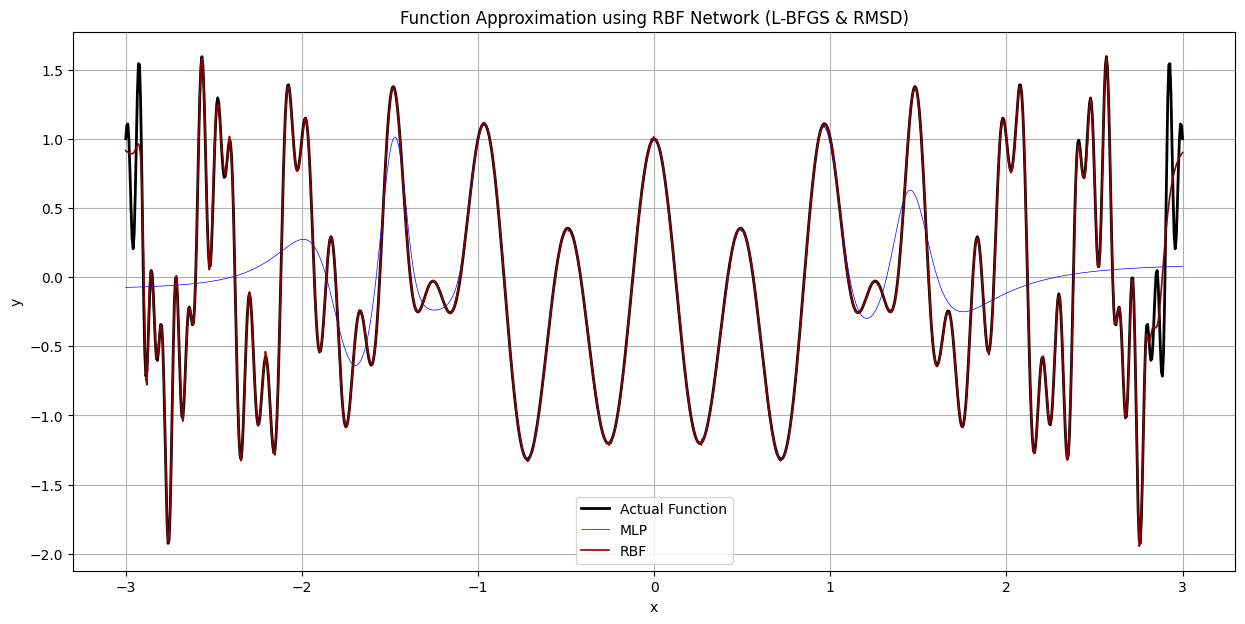

In [56]:
plt.figure(figsize=(15, 7))
plt.plot(x_values, y_values, color='black', linewidth=2, label="Actual Function")
plt.plot(x_values,y_pred_MLP,color='blue',linewidth=0.5 ,label='MLP')
plt.plot(x_values, y_pred_RBF, color='darkred', linewidth=1.2, label="RBF")
plt.grid(True)
plt.legend()
plt.title("Function Approximation using RBF Network (L-BFGS & RMSD)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

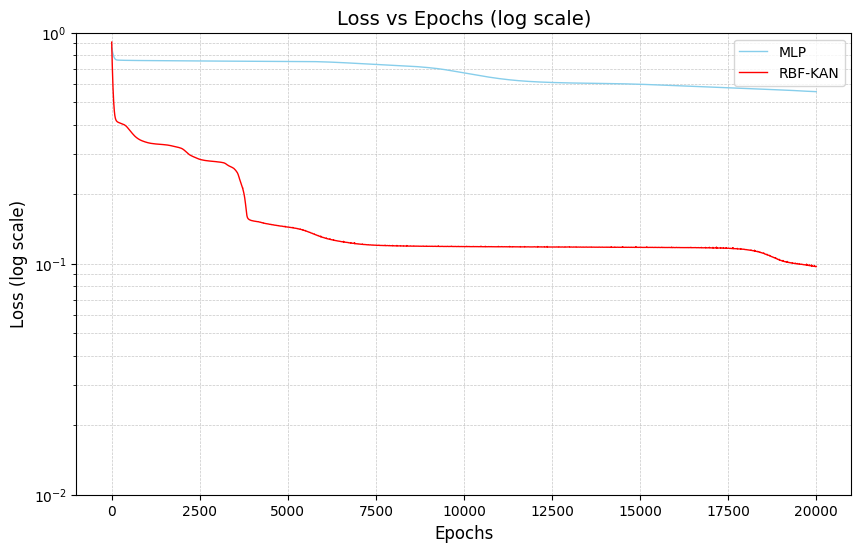

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), loss_history_MLP, color='skyblue', linewidth=1, label="MLP")
plt.plot(range(num_epochs), loss_history_RBF, color='red', linewidth=1, label="RBF-KAN")
plt.yscale('log')  # Set y-axis to log scale
plt.ylim(1e-2, 1e0)  # Set limits from 10^-2 to 10^0
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss (log scale)", fontsize=12)
plt.title("Loss vs Epochs (log scale)", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.show()